In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [317]:
def parse(path):
    raw = pd.read_pickle(path)
    df = pd.DataFrame(map(lambda x: dict(
            cpu=x['request']['cpu'],
            mem=x['request']['mem'],
            lifetime=x['request']['lifetime'],
            is_double=x['request']['is_double'],
            request_type=x['request']['type'],
            request_uuid=x['request']['uuid'],
            time = x['request']['time'],
            server=x['server'],
            action=x['action'],
            energy=x['energy'],
        ), raw))

    scores = []
    scores_end = []
    current_score = 0
    max_tick = df.iloc[[-1]].time.values[0]
    current_score_up_to_end = 0

    losses = []
    current_loss = 0
    
    for ind, row in df.iterrows():
        # for row in df[['request_type', 'cpu', 'mem', 'lifetime']]:
        curr_tick = row.time
        if row.request_type == 0:
            current_score += 1 * row.lifetime * (row.cpu * 0.0698 + row.mem * 0.0078) / 12
            current_score_up_to_end += 1 * min(row.lifetime, max_tick - curr_tick - 1) * (row.cpu * 0.0698 + row.mem * 0.0078) / 12
        else:
            current_loss -= 1 * row.lifetime * (row.cpu * 0.0698 + row.mem * 0.0078) / 60
        # else:
        #     current_score -= 1 * row.lifetime * ()
        scores.append(round(current_score, 3))
        scores_end.append(round(current_score_up_to_end, 3))
        losses.append(round(current_loss, 3))
    df["score"] = scores
    df["cur_score"] = scores_end
    df["loss"] = losses
    return df

def get_mean_util(df):
    tick_server_states = df.groupby('time')['server'].last()

    free_cpu = []
    free_mem = []
    n_servers = len(tick_server_states[0])
    max_cpu = n_servers * 32
    max_mem = n_servers * 128
    for state in tick_server_states:
        current_free_cpu = 0
        current_free_mem = 0
        for server in state:
            server = server[0]
            
            current_free_cpu += server[0]
            current_free_mem += server[1]
        
        free_cpu.append(current_free_cpu / max_cpu)
        free_mem.append(current_free_mem / max_mem)
    
    return 1 - np.mean(free_cpu), 1 - np.mean(free_mem)

def get_mean_util(df):
    tick_server_states = df.groupby('time')['server'].last()

    free_cpu = []
    free_mem = []
    n_servers = len(tick_server_states[0])
    max_cpu = n_servers * 32
    max_mem = n_servers * 128
    for state in tick_server_states:
        current_free_cpu = 0
        current_free_mem = 0
        for server in state:
            server = server[0]
            
            current_free_cpu += server[0]
            current_free_mem += server[1]
        
        free_cpu.append(current_free_cpu / max_cpu)
        free_mem.append(current_free_mem / max_mem)
    
    return 1 - np.mean(free_cpu), 1 - np.mean(free_mem)


def get_energy(df):
    e = df.groupby('time')['energy'].last()
    e = e.reindex(list(range(e.index.min(),e.index.max()+1)),method='bfill')
    current_energy = 0
    energy = []
    for row in e:
        current_energy += row
        energy.append(current_energy)
    
    return energy

def get_rewards(df):
    df2 = df.groupby('time')['score'].last()
    df2.reindex(list(range(df2.index.min(),df2.index.max()+1)),method='bfill')
    return df2

def get_reward_by_tick(df):
    df2 = df.groupby('time')['cur_score'].last()
    df2.reindex(list(range(df2.index.min(),df2.index.max()+1)),method='bfill')
    return df2

def get_losses_by_tick(df):
    df2 = df.groupby('time')['loss'].last()
    df2.reindex(list(range(df2.index.min(),df2.index.max()+1)),method='bfill')
    return df2



In [318]:
dqn25 = parse(r'rule_based_algorithm/dqn.DQNLauncher25.mue.p')
bf25 = parse(r'rule_based_algorithm/best_fit.BestFit25-5.p')
ff25 = parse(r'rule_based_algorithm/first_fit.FirstFit25-5.p')
rand25 = parse(r'rule_based_algorithm/random_pick.RandomPick25-5.p')
rr25 = parse(r'rule_based_algorithm/round_robin.RoundRobin25-5.p')
bp25 = parse(r'rule_based_algorithm/bin_packing.BinPacking25-5.p')
dqnMoney25 = parse(r'rule_based_algorithm/dqn.DQNLauncher25money.p')
dqnChoose25 = parse(r'rule_based_algorithm/dqn.DQNLauncher25choose.p')
ac25 = parse(r'rule_based_algorithm/ac.ACLauncher25.p')
ac25Final = parse(r'rule_based_algorithm/ac.ACLauncher25.mue.p')
dqn25WOW = parse(r'rule_based_algorithm/dqn.DQNLauncher25-5wow.p')
dqn25M = parse(r'rule_based_algorithm/dqn.DQNLauncher25-5-M.p')
ac25ME = parse(r'rule_based_algorithm/ac.ACLauncher25-5-ME.p')

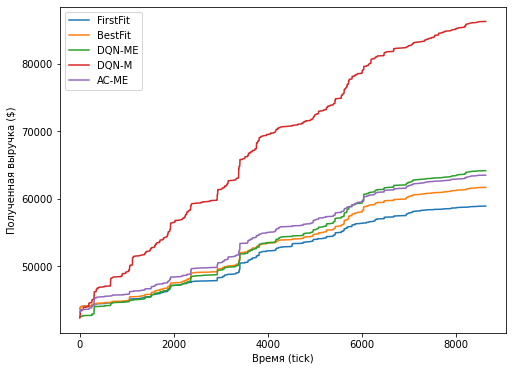

In [354]:

fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot()

ax1.plot(get_rewards(ff25), label="FirstFit")
ax1.plot(get_rewards(bf25), label="BestFit")
# ax1.plot(get_rewards(rr25), label="RoundRobin")
# ax1.plot(get_rewards(bp25), label="BinPacking")
ax1.plot(get_rewards(dqn25), label="DQN-ME")
ax1.plot(get_rewards(dqn25WOW), label="DQN-M")
# ax1.plot(get_rewards(dqn25ME), label="DQN-ME")
# ax1.plot(get_rewards(dqnMoney25), label="dqnMoney")
# ax1.plot(get_rewards(ac25Final), label="AC-MUE")
ax1.plot(get_rewards(ac25ME), label="AC-ME")
# ax1.plot(get_rewards(ac25_5choose), label="ACChoose")

# ax1.plot(get_rewards(dqnChoose25), label="dqnChoose25")
# ax1.plot(x[40:],y[40:], s=10÷ c='r', marker="o", label='second')
plt.legend(loc='upper left');
# plt.title("прибыль за успешные аллокации")
plt.xlabel("Время (tick)")
plt.ylabel("Полученная выручка ($)")
plt.show()

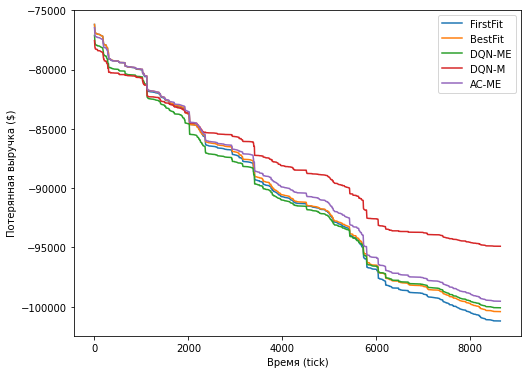

In [365]:

fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot()

ax1.plot(get_losses_by_tick(ff25).iloc[4:], label="FirstFit")
ax1.plot(get_losses_by_tick(bf25).iloc[4:], label="BestFit")
# ax1.plot(get_losses_by_tick(rr25), label="RoundRobin")
# ax1.plot(get_losses_by_tick(bp25), label="BinPacking")
ax1.plot(get_losses_by_tick(dqn25).iloc[4:], label="DQN-ME")
ax1.plot(get_losses_by_tick(dqn25WOW).iloc[4:], label="DQN-M")
# ax1.plot(get_losses_by_tick(dqnMoney25), label="dqnMoney")
# ax1.plot(get_losses_by_tick(ac25Final).iloc[4:], label="AC-MUE")
ax1.plot(get_losses_by_tick(ac25ME).iloc[4:], label="AC-ME")
# ax1.plot(ac25_5choose.groupby('time')['score'].last(), label="ACChoose")

# ax1.plot(dqnChoose25.groupby('time')['score'].last(), label="dqnChoose25")
# ax1.plot(x[40:],y[40:], s=10÷ c='r', marker="o", label='second')
plt.legend(loc='upper right');
# plt.title("прибыль за успешные аллокации")
plt.xlabel("Время (tick)")
plt.ylabel("Потерянная выручка ($)")
plt.show()

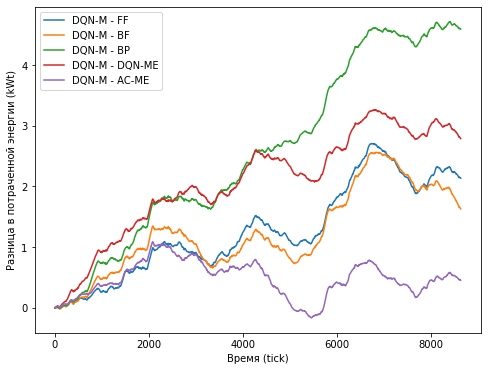

In [355]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot()

dqnf_energy = get_energy(dqn25WOW)
dqn25Money_energy = get_energy(dqn25)
bf25_energy = get_energy(bf25)
ff25_energy = get_energy(ff25)
bp25_energy = get_energy(bp25)
ac25_energy = get_energy(ac25ME)

ax1.plot([dqnf_energy[i] - ff25_energy[i]  for i in range(len(dqnf_energy))], label="DQN-M - FF")
ax1.plot([dqnf_energy[i] - bf25_energy[i]  for i in range(len(dqnf_energy))], label="DQN-M - BF")
ax1.plot([dqnf_energy[i] - bp25_energy[i]  for i in range(len(dqnf_energy))], label="DQN-M - BP")
ax1.plot([dqnf_energy[i] - dqn25Money_energy[i]  for i in range(len(dqnf_energy))], label="DQN-M - DQN-ME")
ax1.plot([dqnf_energy[i] - ac25_energy[i]  for i in range(len(dqnf_energy))], label="DQN-M - AC-ME")


plt.legend(loc='upper left');
plt.xlabel("Время (tick)")
plt.ylabel("Разница в потраченной энергии (kWt)")
plt.show()

In [185]:
ff5_0 = parse(r'rule_based_algorithm/first_fit.FirstFit5-0.p')
print(get_mean_util(ff5_0))
print(get_energy(ff5_0)[-1])
print(ff5_0.iloc[[-1]]["score"])



8636
(0.9960634087980857, 0.5883932679919013)
310.36219599470496
9998    12685.349
Name: score, dtype: float64


In [186]:
bf5_0 = parse(r'rule_based_algorithm/best_fit.BestFit5-0.p')
print(get_mean_util(bf5_0))
print(get_energy(bf5_0)[-1])
print(bf5_0.iloc[[-1]]["score"])


8636
(0.9967467329284005, 0.5651153828455733)
311.6549483947456
9998    11777.553
Name: score, dtype: float64


In [187]:
bp5_0 = parse(r'rule_based_algorithm/bin_packing.BinPacking5-0.p')
print(get_mean_util(bp5_0))
print(get_energy(bp5_0)[-1])
print(bp5_0.iloc[[-1]]["score"])


8636
(0.9964890484078778, 0.5641070771212957)
310.96434977278113
9998    10991.584
Name: score, dtype: float64


In [188]:
rr5_0 = parse(r'rule_based_algorithm/round_robin.RoundRobin5-0.p')
print(get_mean_util(rr5_0))
print(get_energy(rr5_0)[-1])
print(rr5_0.iloc[[-1]]["score"])


8636
(0.996376311430149, 0.5798258328731825)
310.3047532103956
9998    12346.798
Name: score, dtype: float64


In [189]:
rp5_0 = parse(r'rule_based_algorithm/random_pick.RandomPick5-0.p')
print(get_mean_util(rp5_0))
print(get_energy(rp5_0)[-1])
print(rp5_0.iloc[[-1]]["score"])


8636
(0.9967559359469906, 0.5569695610160132)
311.52557929605246
9998    11969.688
Name: score, dtype: float64


In [190]:
ff5_5 = parse(r'rule_based_algorithm/first_fit.FirstFit5-5.p')
print(get_mean_util(ff5_5))
print(get_energy(ff5_5)[-1])
print(ff5_5.iloc[[-1]]["score"])


8637
(0.9994592125427325, 0.5781599964635152)
485.11214074119925
48302    10792.543
Name: score, dtype: float64


In [191]:
bf5_5 = parse(r'rule_based_algorithm/best_fit.BestFit5-5.p')
print(get_mean_util(bf5_5))
print(get_energy(bf5_5)[-1])
print(bf5_5.iloc[[-1]]["score"])

8637
(0.9992695667571715, 0.5647768858458269)
484.6995711363852
47916    11952.828
Name: score, dtype: float64


In [192]:
bp5_5 = parse(r'rule_based_algorithm/bin_packing.BinPacking5-5.p')
print(get_mean_util(bp5_5))
print(get_energy(bp5_5)[-1])
print(bp5_5.iloc[[-1]]["score"])

8637
(0.9994476846942383, 0.5668290473665606)
484.7786408737302
48313    11481.567
Name: score, dtype: float64


In [193]:
rr5_5 = parse(r'rule_based_algorithm/round_robin.RoundRobin5-5.p')
print(get_mean_util(rr5_5))
print(get_energy(rr5_5)[-1])
print(rr5_5.iloc[[-1]]["score"])

8637
(0.9994562654721207, 0.5570158699752445)
484.89115811511874
48423    11168.806
Name: score, dtype: float64


In [194]:
rp5_5 = parse(r'rule_based_algorithm/random_pick.RandomPick5-5.p')
print(get_mean_util(rp5_5))
print(get_energy(rp5_5)[-1])
print(rp5_5.iloc[[-1]]["score"])


8637
(0.9993230088495575, 0.5607256637168141)
484.9477920308709
48172    11416.312
Name: score, dtype: float64


In [196]:
rp25_5 = parse(r'rule_based_algorithm/random_pick.RandomPick25-5.p')
print("rp")
print(get_mean_util(rp25_5))
print(get_energy(rp25_5)[-1])
print(rp25_5.iloc[[-1]]["score"])

ff25_5 = parse(r'rule_based_algorithm/first_fit.FirstFit25-5.p')
print("ff")
print(get_mean_util(ff25_5))
print(get_energy(ff25_5)[-1])
print(ff25_5.iloc[[-1]]["score"])

bf25_5 = parse(r'rule_based_algorithm/best_fit.BestFit25-5.p')
print("bf")
print(get_mean_util(bf25_5))
print(get_energy(bf25_5)[-1])
print(bf25_5.iloc[[-1]]["score"])

bp25_5 = parse(r'rule_based_algorithm/bin_packing.BinPacking25-5.p')
print("bp")
print(get_mean_util(bp25_5))
print(get_energy(bp25_5)[-1])
print(bp25_5.iloc[[-1]]["score"])

rr25_5 = parse(r'rule_based_algorithm/round_robin.RoundRobin25-5.p')
print("rr")
print(get_mean_util(rr25_5))
print(get_energy(rr25_5)[-1])
print(rr25_5.iloc[[-1]]["score"])


8637
rp
(0.9963679712657915, 0.7049866856576665)
2312.9625910818577
36090    60349.721
Name: score, dtype: float64
8637
ff
(0.9966523538860744, 0.6999908871864574)
2317.9123263955116
36999    58883.931
Name: score, dtype: float64
8637
bf
(0.9965416563352343, 0.6912684416067444)
2310.590774565935
36032    61658.895
Name: score, dtype: float64
8637
bp
(0.9963480271270037, 0.6915708230579531)
2320.4733298122883
36596    61515.012
Name: score, dtype: float64
8637
rr
(0.9959050334738409, 0.6888343044879741)
2310.5905914902687
36470    60359.065
Name: score, dtype: float64


In [198]:
print("dqn final")
print(get_mean_util(dqn25))
print(get_energy(dqn25)[-1])
print(dqn25.iloc[[-1]]["score"])


print("dqn money")
print(get_mean_util(dqnMoney25))
print(get_energy(dqnMoney25)[-1])
print(dqnMoney25.iloc[[-1]]["score"])

dqn final
(0.9908005529722257, 0.6883487024004022)
2278.3783646523952
34191    64133.893
Name: score, dtype: float64
dqn money
(0.9888591867469879, 0.6938827183734939)
2279.9641813337803
35015    61876.879
Name: score, dtype: float64


In [199]:
ac25_5final = parse(r'rule_based_algorithm/ac.ACLauncher25-5.p')
print("rr")
print(get_mean_util(ac25_5final))
print(get_energy(ac25_5final)[-1])
print(ac25_5final.iloc[[-1]]["score"])

8637
rr
(0.9966117238815219, 0.6896012517040526)
2311.4410207271576
36432    60362.348
Name: score, dtype: float64


In [200]:
ac25_5choose = parse(r'rule_based_algorithm/ac.ACLauncher25-5.p')
print("rr")
print(get_mean_util(ac25_5choose))
print(get_energy(ac25_5choose)[-1])
print(ac25_5choose.iloc[[-1]]["score"])

8637
rr
(0.9942533936651584, 0.6917125439919558)
2278.2351412773132
34294    60629.373
Name: score, dtype: float64


In [214]:
ac5_5valid = parse(r'rule_based_algorithm/ac.ACLauncher5-0.p')
print("rr")
print(get_mean_util(ac5_5valid))
print(get_energy(ac5_5valid)[-1])
print(ac5_5valid.iloc[[-1]]["score"])

8636
rr
(0.9965442665194184, 0.5614002392784834)
310.7819185219705
9998    11976.37
Name: score, dtype: float64


In [209]:
ac5_5simple = parse(r'rule_based_algorithm/ac.ACLauncher5-0.p')
print("rr")
print(get_mean_util(ac5_5simple))
print(get_energy(ac5_5simple)[-1])
print(ac5_5simple.iloc[[-1]]["score"])

8636
rr
(0.9488933370145408, 0.6141180057058715)
308.03017480671406
9998    12506.793
Name: score, dtype: float64


In [210]:
ac5_5money = parse(r'rule_based_algorithm/ac.ACLauncher5-5.p')
print("rr")
print(get_mean_util(ac5_5money))
print(get_energy(ac5_5money)[-1])
print(ac5_5money.iloc[[-1]]["score"])

8637
rr
(0.9994592125427325, 0.5781599964635152)
485.11214108765125
48302    10792.543
Name: score, dtype: float64


In [201]:
dqn5_0valid = parse(r'rule_based_algorithm/dqn.DQNLauncher5-5.p')
print("rr")
print(get_mean_util(dqn5_0valid))
print(get_energy(dqn5_0valid)[-1])
print(dqn5_0valid.iloc[[-1]]["score"])

8637
rr
(0.9992055771725032, 0.5671018305624337)
484.0128677673638
48131    12100.657
Name: score, dtype: float64


In [218]:
dqn5_0money = parse(r'rule_based_algorithm/dqn.DQNLauncher5-0.p')
print("rr")
print(get_mean_util(dqn5_0money))
print(get_energy(dqn5_0money)[-1])
print(dqn5_0money.iloc[[-1]]["score"])

8636
rr
(0.6055011043622308, 0.4057938753911283)
297.2652039565146
9998    9446.949
Name: score, dtype: float64


In [216]:
dqn5_0money = parse(r'rule_based_algorithm/dqn.DQNLauncher5-0.p')
print("rr")
print(get_mean_util(dqn5_0money))
print(get_energy(dqn5_0money)[-1])
print(dqn5_0money.iloc[[-1]]["score"])

8636
rr
(0.9964016197312718, 0.5557541873734585)
310.5036327764392
9998    12417.037
Name: score, dtype: float64


In [217]:
dqn5_5money = parse(r'rule_based_algorithm/dqn.DQNLauncher5-5.p')
print("rr")
print(get_mean_util(dqn5_5money))
print(get_energy(dqn5_5money)[-1])
print(dqn5_5money.iloc[[-1]]["score"])

8637
rr
(0.9984989953906158, 0.5553735521805933)
484.8272892013192
47145    14113.485
Name: score, dtype: float64


In [221]:
dqn25_5free = parse(r'rule_based_algorithm/dqn.DQNLauncher25choose.p')
print("rr")
print(get_mean_util(dqn25_5free))
print(get_energy(dqn25_5free)[-1])
print(dqn25_5free.iloc[[-1]]["score"])

8637
rr
(0.30472615894039734, 0.2268158112582781)
1973.3912616372108
30628    43100.73
Name: score, dtype: float64


In [223]:
ac25_5free = parse(r'rule_based_algorithm/ac.ACLauncher25-5noopt.p')
print("rr")
print(get_mean_util(ac25_5free))
print(get_energy(ac25_5free)[-1])
print(ac25_5free.iloc[[-1]]["score"])

8637
rr
(0.9799346268656717, 0.6870815671641791)
2396.809341609478
38913    57420.036
Name: score, dtype: float64


In [ ]:
ac25_5final = parse(r'rule_based_algorithm/ac.ACLauncher25-5.p')
print("rr")
print(get_mean_util(ac25_5final))
print(get_energy(ac25_5final)[-1])
print(ac25_5final.iloc[[-1]]["score"])

In [240]:
print(get_mean_util(dqnMoney25))
print(get_energy(dqnMoney25)[-2])
print(dqnMoney25.iloc[[-1]]["score"])

(0.9888591867469879, 0.6938827183734939)
2279.678147405386
35015    61876.879
Name: score, dtype: float64


In [237]:
print(get_mean_util(dqn25))
print(get_energy(dqn25)[-1])
print(dqn25.iloc[[-1]]["score"])

(0.9908005529722257, 0.6883487024004022)
2278.3783646523952
34191    64133.893
Name: score, dtype: float64
